In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "8"

import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from pathlib import Path

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW




import sbi 
from sbi import analysis
from sbi import utils as utils
from sbi.inference import NLE, NPE
from sbi.neural_nets import posterior_nn, likelihood_nn 
from torch.utils import data

device="cuda"

In [7]:
#normalization function
        
def normalize(dataset, is_observable = False, dataset_name=None):
    if dataset_name is not None:
        mean = np.load(f'./params_compressor/normalization_for_compressor_{dataset_name}.npz')['mean']
        std = np.load(f'./params_compressor/normalization_for_compressor_{dataset_name}.npz')['std']
    if is_observable:
        # the shape in this case is (N, N_particles, 6)
        dataset_original_shape = dataset.shape
        normalized_dataset = dataset.reshape(-1, dataset.shape[-1])
        normalized_dataset = (normalized_dataset - mean)/ (std + 1e-8) 
        normalized_dataset = normalized_dataset.reshape(dataset_original_shape)
    else:
        normalized_dataset = (dataset - mean)/ (std + 1e-8) 

    return normalized_dataset

In [ ]:
data_path = './data/data_NFW/'
pattern = re.compile(r"chunk_(\d+)\.npz")  # capture any number of digits
files = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) < 20_000 and int(m.group(1)) > 0
)
theta_list, x_list, score_list = [], [], []

for f in files:
    data_file = np.load(f)
    theta_list.append(data_file["theta"])
    x_list.append(data_file["x"])
    
dataset_theta = np.array(theta_list,).reshape(-1, 5)
dataset_y = np.array(x_list, ).reshape(-1, 10_000, 6)


# #normalize the dataset
# dataset_theta = torch.tensor(normalize(dataset_theta, dataset_name='theta'))
# dataset_y = torch.tensor(normalize(dataset_y, is_observable=True, dataset_name='y'))

#rename
x = torch.tensor(dataset_y)
theta = torch.tensor(dataset_theta)

In [9]:
class DeepSetsEncoder(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=32):
        super().__init__()
        self.phi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        """
        Args:
            x: Tensor of shape [N, D] (unbatched) or [B, N, D] (batched)
        Returns:
            summary vector of shape [output_dim] or [B, output_dim]
        """
        if x.dim() == 2:
            # Unbatched input: [N_particles, 6]
            x_phi = self.phi(x)                  # [N, output_dim]
            summary = x_phi.mean(dim=0)          # [output_dim]
        elif x.dim() == 3:
            # Batched input: [B, N_particles, 6]
            B, N, D = x.shape
            x_phi = self.phi(x.view(-1, D))      # [B * N, output_dim]
            x_phi = x_phi.view(B, N, -1)         # [B, N, output_dim]
            summary = x_phi.mean(dim=1)          # [B, output_dim]
        else:
            raise ValueError(f"Expected shape (N, D) or (B, N, D), got {x.shape}")
        
        return summary

In [10]:
# Define training params
training_batch_size = 200
learning_rate = 5e-4
validation_fraction = 0.1  # 10% of the data will be used for validation


In [11]:
from torch.utils.data.sampler import SubsetRandomSampler

dataset = data.TensorDataset(theta, x)
num_examples = theta.size(0)

# Select random train and validation splits from (theta, x) pairs.
num_training_examples = int((1 - validation_fraction) * num_examples)
num_validation_examples = num_examples - num_training_examples

permuted_indices = torch.randperm(num_examples)
train_indices, val_indices = (
    permuted_indices[:num_training_examples],
    permuted_indices[num_training_examples:],
)

train_loader_kwargs = {
    "batch_size": min(training_batch_size, num_training_examples),
    "drop_last": True,
    "sampler": SubsetRandomSampler(train_indices.tolist()),
}
val_loader_kwargs = {
    "batch_size": min(training_batch_size, num_validation_examples),
    "shuffle": False,
    "drop_last": True,
    "sampler": SubsetRandomSampler(val_indices.tolist()),
}

train_loader_kwargs = dict(train_loader_kwargs)
val_loader_kwargs = dict(val_loader_kwargs)

train_loader = data.DataLoader(dataset, **train_loader_kwargs)
val_loader = data.DataLoader(dataset, **val_loader_kwargs)

AttributeError: 'NpzFile' object has no attribute 'TensorDataset'

In [ ]:
prior_min = [0.5, 1e3, 0.1, 5e11, 1.0]
prior_max = [10.0, 1e5, 1.0, 1.5e12, 20.0]
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min, device=device), high=torch.as_tensor(prior_max, device=device)
)


# instantiate the custom embedding_net
embedding_net_custom = DeepSetsEncoder().to(device=device)

# Instantiate the conditional neural density estimator
# neural_posterior = likelihood_nn(model="maf", embedding_net=embedding_net_custom)
neural_posterior = posterior_nn(model="maf", embedding_net=embedding_net_custom)
inference = NPE(prior=prior, density_estimator=neural_posterior, device=device)

theta = theta[:15_000]
x = x[:15_000]
# density_estimator = inference.append_simulations(theta.to(device=device), x.to(device=device)).train()



/export/home/vgiusepp/miniconda3/envs/sbi_ds/lib/python3.12/site-packages/sbi/neural_nets/factory.py:334: UserWarning: The passed embedding net will be moved to cpu for
                        constructing the net building function.
  check_net_device(embedding_net, "cpu", embedding_net_warn_msg),


/export/home/vgiusepp/miniconda3/envs/sbi_ds/lib/python3.12/site-packages/sbi/inference/trainers/npe/npe_base.py:158: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/export/home/vgiusepp/miniconda3/envs/sbi_ds/lib/python3.12/site-packages/sbi/inference/trainers/npe/npe_base.py:158: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.02 GiB. GPU 0 has a total capacity of 10.75 GiB of which 519.56 MiB is free. Including non-PyTorch memory, this process has 10.24 GiB memory in use. Of the allocated memory 10.06 GiB is allocated by PyTorch, and 1.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
data_path = './data/data_NFW/'
pattern = re.compile(r"chunk_(\d+)\.npz")  # capture any number of digits
files = sorted(
    f for f in Path(data_path).glob("chunk_*.npz")
    if (m := pattern.fullmatch(f.name)) and int(m.group(1)) > 10_000 and int(m.group(1)) < 10_002
)
theta_list, x_list, score_list = [], [], []

for f in files:
    data = np.load(f)
    theta_list.append(data["theta"])
    x_list.append(data["x"])
    score_list.append(data["score"]) 
    
dataset_theta = np.array(theta_list,).reshape(-1, 5)
dataset_y = np.array(x_list, ).reshape(-1, 10_000, 6)


#normalize the dataset
# dataset_theta = torch.tensor(normalize(dataset_theta, dataset_name='theta'))
# dataset_y = torch.tensor(normalize(dataset_y, is_observable=True, dataset_name='y'))

#rename
x = torch.tensor(dataset_y)
theta = torch.tensor(dataset_theta)

true_parameter = theta[0].to(device=device)
x_observed = x[0].to(device=device)

posterior = inference.build_posterior(density_estimator)
samples = posterior.sample((5000,), x=x_observed.to(device=device), show_progress_bars=True)


# create the figure
# fig, ax = analysis.pairplot(
#     samples.cpu().numpy(),
#     points=true_parameter.cpu().numpy(),
#     labels=["t_end", "Mtot_plummer", "a_plummer", "M_NFW", "r_s"],
#     limits=np.stack([prior_min, prior_max], axis=1),
#     fig_kwargs=dict(
#         points_colors="r",
#         points_offdiag={"markersize": 6},
#     ),
#     figsize=(5, 5),
# )


Drawing 5000 posterior samples: 5925it [00:00, 103721.04it/s]           


In [ ]:
import pandas as pd

df_samples = pd.DataFrame(samples.cpu().numpy(), columns=["$t_{end}$", "$M_{plummer}$", "$a_{plummer}$", "$M_{NFW}$", "$r_s$"])
df_true = pd.DataFrame(true_parameter.cpu().numpy().reshape((1, 5)), columns=["$t_{end}$", "$M_{plummer}$", "$a_{plummer}$", "$M_{NFW}$", "$r_s$"])

Parameter $t_{end}$ in chain Posterior samples is not constrained
Parameter $a_{plummer}$ in chain Posterior samples is not constrained
Parameter $M_{NFW}$ in chain Posterior samples is not constrained
Parameter $r_s$ in chain Posterior samples is not constrained


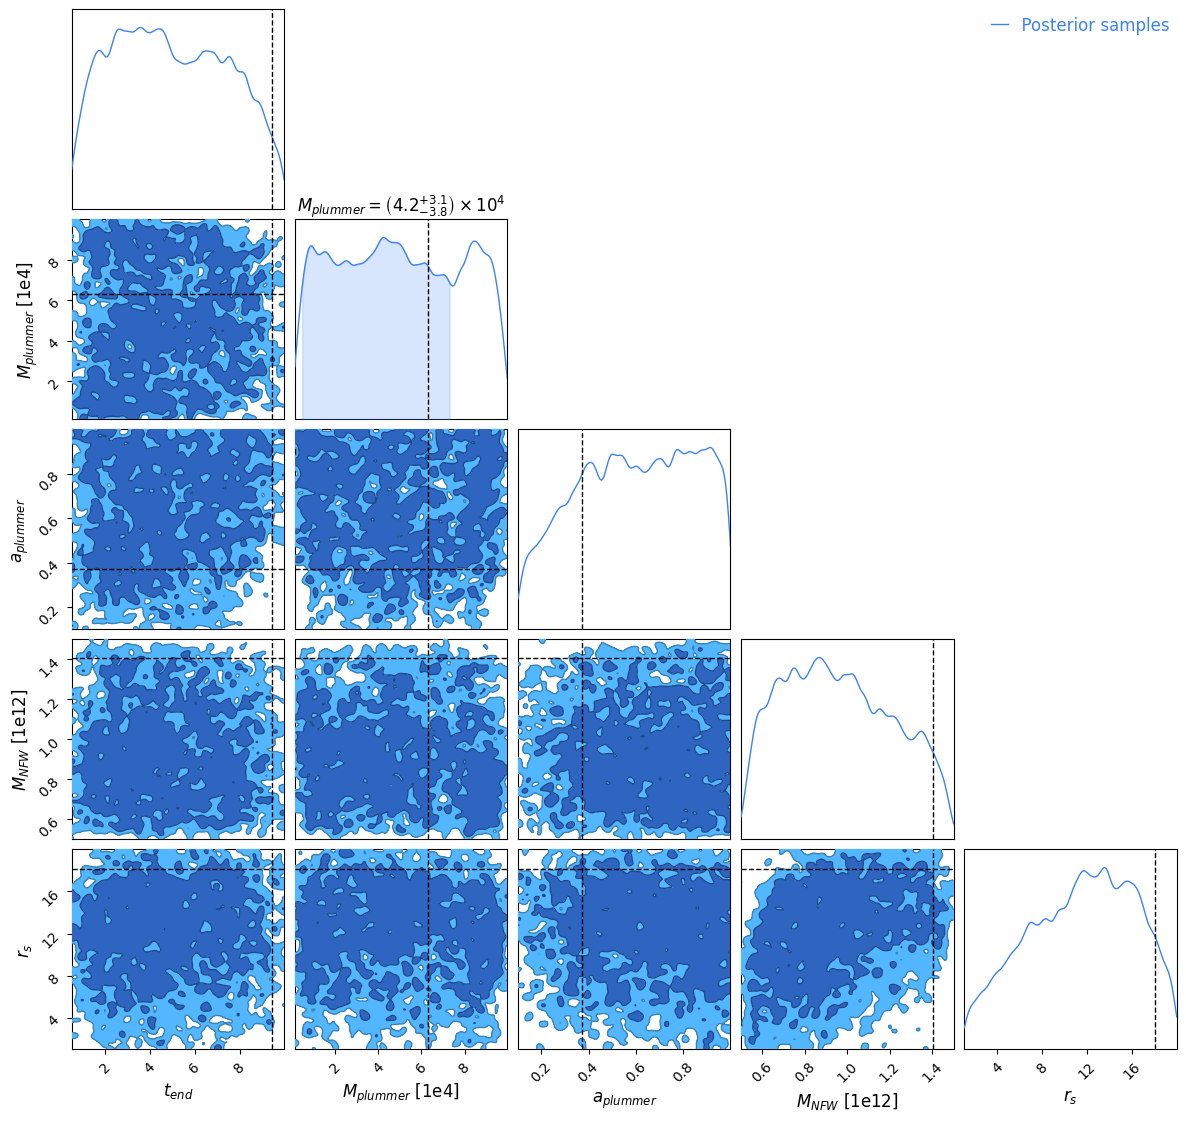

In [ ]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth, PlotConfig


c = ChainConsumer()
c.add_chain(Chain(samples=df_samples, name='Posterior samples'))
c.add_truth(Truth(location=df_true.to_dict('records')[0], name='True' ),)
c.set_plot_config(PlotConfig(show_legend=True))
fig = c.plotter.plot()
